# A/B тестирование для интернет-магазина

В этом проекте мы будем заниматься ~~тем, для чего нужны аналитики~~ анализом результатов А/В-тестирования! Нам понадобится немногое - `pandas`, `matplotlib`, `numpy` и `scipy`.
По легенде, вместе с маркетологами интернет-магазина мы подготовили список гипотез для увеличения выручки. Наша задача - приоритизировать гипотезу, запустить А/В-тест и проанализировать её результаты. Разобьем работу на этапы:

1. [Импорт и подготовка данных](#import)
2. [Приоритизация гипотез](#prior)
3. [А/В-тестирование](#ab)
    1. [Объединение данных и кумулятивные метрики](#met)
    2. [Поиск аномалий](#abn)
    3. [Собственно А/В-тестирование для изначальных и очищенных данных](#test)
4. [Итоговый вывод и принятие решения](#concl)

За работу!

## <a id="import">Импорт и подготовка данных</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Посмотрим на "Гипотезы":

In [3]:
pd.set_option('display.max_colwidth', 300)
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В таблице "Гипотезы" содержится информация о 9 гипотезах (охват, влияние, уверенность, затраты). Названия столбцов можно сделать лучше.

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

Теперь посмотрим на "Заказы" и "Посетителей":

In [5]:
data = [orders, visitors]
for data in data:
    print('Первый взгляд:')
    display(data.head(10))
    print('Общая информация:')
    display(data.info())
    display(data.describe())
    print('Дублирующихся значений: ', data.duplicated().sum())
    print('***')

Первый взгляд:


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Дублирующихся значений:  0
***
Первый взгляд:


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


Дублирующихся значений:  0
***


В датафрейме "Заказы" лежит информация о 1197 транзакциях: id транзакции, посетителя, дата, сумма транзакции и группа. В таблице "Посетители" содержатся данные о 62 днях эксперимента: дата, группа и количество посетителей в ней. Заметим, что максимальный заказ стоит более 1,2 млн, в то время как медиана - около 3 тысяч. Запомним эту аномалию. Время в обоих таблицах необходимо преобразовать в datetime, а столбцы первого датафрейма слегка изменить:

In [6]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
orders.columns = orders.columns.str.lower()

## <a id="prior">Приоритизация гипотез</a>

Применим фреймворки для приоритизации и сравним результаты:

In [7]:
hypothesis['ice'] = ((hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']).round(2)
hypothesis['rice'] = ((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']).round(2)
display('Фреймворк ICE:', hypothesis.sort_values(by='ice', ascending=False))
display('Фреймворк RICE:', hypothesis.sort_values(by='rice', ascending=False))

'Фреймворк ICE:'

,hypothesis,reach,impact,confidence,efforts,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


'Фреймворк RICE:'

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


По данным ICE гипотеза "Запустить акцию, дающую скидку на товар в день рождения" выигрывает: у нее высокое влияние, уверенность и относительно небольшая стоимость проверки. Следом идет "Добавить два новых канала" с наивысшим влиянием, высокой уверенностью и относительно дешевая в проверке; за ней - "Добавить форму подписки на основные страницы, чтобы собрать базу данных" с высоким влиянием, уверенностью и низкими затратами. При применении RICE гипотеза "Добавить форму подписки..." вырывается вперед за счет максимального охвата, следом за ней - "Добавить блоки рекомендаций" с высоким охватом и уверенностью и низкими затратами, последняя в тройке - "Добавить 2 новых канала". Как мы видим, гипотезы с индексами 0 и 7 входят в топ-3 по данным обеих метрик, именно из них следует выбирать наиболее интересную!

## <a id="ab">Собственно А/В-тестирование</a>

Ура! Мы провели А/В-тест и получили кучу интересной информации. Настало время её анализировать. Для начала расчитаем основные кумулятивные метрики.

### <a id="met">Объединение данных и расчет кумулятивных метрик</a>

Саккумулируем наши данные в датафрейм с понятными столбцами и начнем анализ. Первый в очереди - график среднего чека.

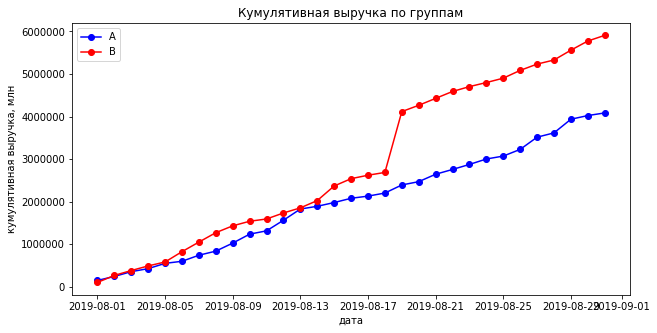

In [8]:
dates_groups = orders[['date','group']].drop_duplicates()
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], \
    orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, \
    'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], \
    visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
    .sort_values(by=['date','group'])
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(10, 5))
plt.title('Кумулятивная выручка по группам')
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], 'bo-', label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], 'ro-', label='B')
plt.xlabel('дата')
plt.ylabel('кумулятивная выручка, млн')
plt.legend()
plt.show()

Кумулятивная выручка растет в обеих группах практически параллельно, но 20 августа выручка группы В выстреливает вверх - возможно, за счет заказов-выбросов.

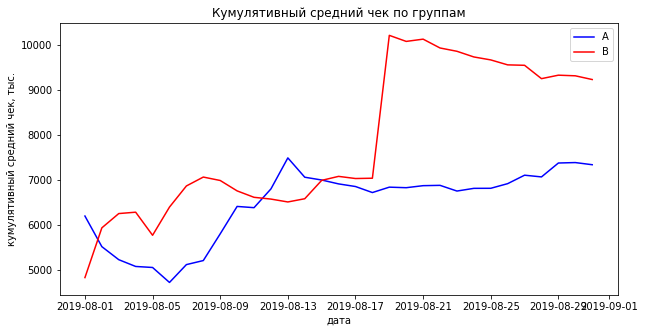

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], 'b', label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], 'r',label='B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('дата')
plt.ylabel('кумулятивный средний чек, тыс.')
plt.legend()
plt.show()

Кумулятивный средний чек в первой половине периода значительно колебался, затем в группе В кто-то заказал несколько ящиков черной икры, а потом средние чеки обеих групп несколько стабилизировались (хотя у В он склонен снижаться)

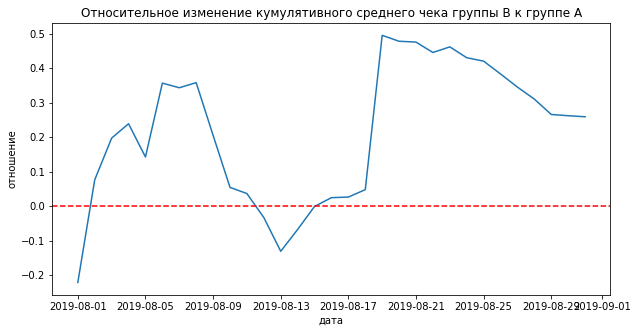

In [10]:
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, \
    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10, 5))
plt.plot(merged_cumulative_revenue['date'], \
    (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])\
    /(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.xlabel('дата')
plt.ylabel('отношение')
plt.show()

На графике нестабильность и вероятные выбросы, а также тенденция к снижению выручки группы В.

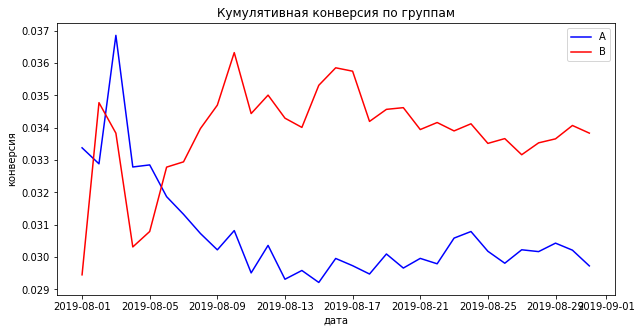

In [11]:
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']
plt.figure(figsize=(10, 5))
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], 'b', label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], 'r', label='B')
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('дата')
plt.ylabel('конверсия')
plt.legend()
plt.show()

Кумулятивная конверсия в группе В выше! Кажется, пользователи действительно чаще покупают.

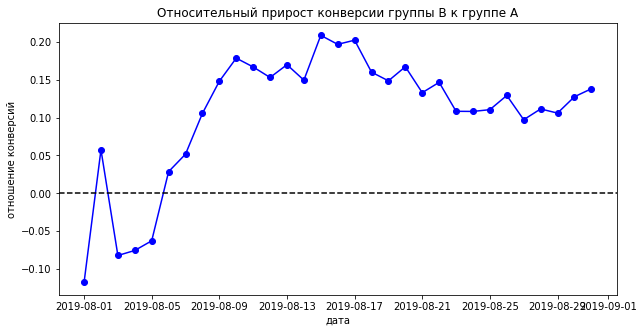

In [12]:
merged_cumulative_conversions = cumulative_data_A[['date','conversion']]\
    .merge(cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])
plt.figure(figsize=(10,5))
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_B']\
    /merged_cumulative_conversions['conversion_A']-1, 'bo-')
plt.title('Относительный прирост конверсии группы B к группе A')
plt.xlabel('дата')
plt.ylabel('отношение конверсий')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

График подтверждает предыдущий вывод. Можно сказать, что отношения конверсий стабилизировались. 

### <a id="abn">Поиск аномалий</a>

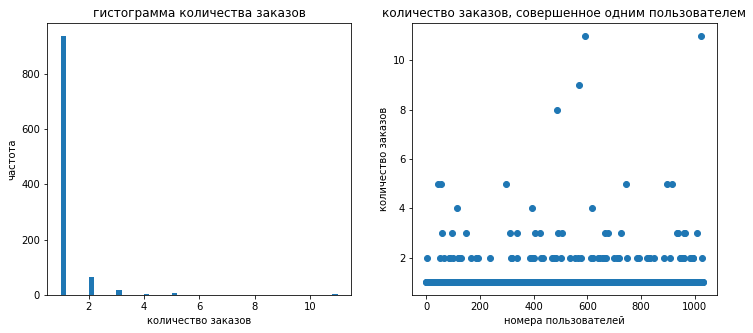

In [13]:
orders_by_users = orders.groupby('visitorid', as_index=False).agg({'transactionid':'nunique'})
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xlabel('количество заказов')
plt.ylabel('частота')
plt.hist(orders_by_users['transactionid'], bins=50)
plt.title('гистограмма количества заказов')
plt.subplot(1,2,2)
plt.xlabel('номера пользователей')
plt.ylabel('количество заказов')
plt.scatter(pd.Series(range(0,len(orders_by_users['transactionid']))), orders_by_users['transactionid'])
plt.title('количество заказов, совершенное одним пользователем')
plt.show()

Подавляющее большинство пользователей совершают 1-2 заказа, а тех, кто сделал больше шести, можно пересчитать по пальцам опытного слесаря. Отыщем границу, по которой будем отсекать выбросы:

In [14]:
print(np.percentile(orders_by_users['transactionid'], [90, 95, 99]))

[1. 2. 4.]


Больше 4-х заказов практически никто не делает. Печально, конечно, что верные клиенты - это аномалии... Посмотрим теперь на выручку.

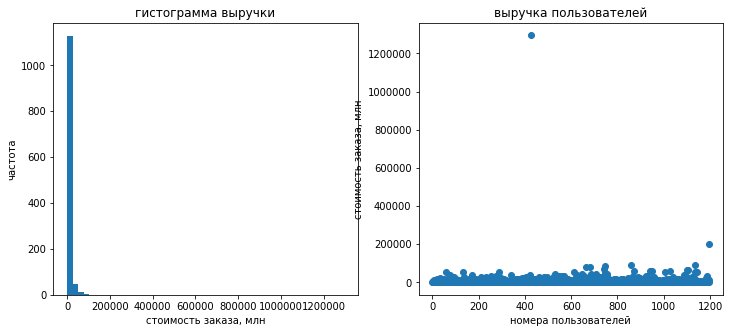

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(orders['revenue'], bins=50)
plt.title('гистограмма выручки')
plt.xlabel('стоимость заказа, млн')
plt.ylabel('частота')
plt.subplot(1,2,2)
plt.title('выручка пользователей')
plt.xlabel('номера пользователей')
plt.ylabel('стоимость заказа, млн')
plt.scatter(pd.Series(range(0,len(orders['revenue']))), orders['revenue'])
plt.show()

Видно, что выбросы есть, но их очень мало - буквально два. Убедимся в этом, вызвав функцию percentile:

In [16]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


99 процентов заказов находятся под чертой в 59 тысяч, при этом максимальный заказ составляет более 1,2 млн. Без него аналитику будет легче.

### <a id="test">Собственно А/В-тестирование для изначальных и очищенных данных</a>

Создадим датафрейм с привычным названием, в который положим все имеющиеся данные: и кумулятивные, и нет:

In [17]:
orders_A_daily = (
    orders[orders['group'] == 'A']
    .groupby('date', as_index=False)
    .agg({'transactionid': 'nunique', 'revenue': 'sum'})
    .rename(columns={'transactionid':'orders_A_daily', 'revenue': 'revenue_A_daily'})
)
orders_B_daily = (
    orders[orders['group'] == 'B']
    .groupby('date', as_index=False)
    .agg({'transactionid': 'nunique', 'revenue': 'sum'})
    .rename(columns={'transactionid':'orders_B_daily', 'revenue': 'revenue_B_daily'})
)
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']].rename(columns={'visitors':'visitors_A_daily'})
visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']].rename(columns={'visitors':'visitors_B_daily'})
visitors_A_cummulative = (
    cumulative_data[cumulative_data['group'] == 'A'][['date', 'visitors']]
    .rename(columns = {'visitors':'visitors_A_cummulative'})
)
visitors_B_cummulative = (
    cumulative_data[cumulative_data['group'] == 'B'][['date', 'visitors']]
    .rename(columns = {'visitors':'visitors_B_cummulative'})
)
orders_A_cumulative = (
    cumulative_data[cumulative_data['group'] == 'A'][['date', 'orders', 'revenue']]
    .rename(columns = {'orders':'orders_A_cummulative', 'revenue':'revenue_A_cumulative'})
)
orders_B_cumulative = (
    cumulative_data[cumulative_data['group'] == 'B'][['date', 'orders', 'revenue']]
    .rename(columns = {'orders':'orders_B_cummulative', 'revenue':'revenue_B_cumulative'})
)
data = (
    orders_A_daily.merge(orders_B_daily, on='date', how='left')
    .merge(orders_A_cumulative, on='date', how='left')
    .merge(orders_B_cumulative, on='date', how='left')
    .merge(visitors_A_daily, on='date', how='left')
    .merge(visitors_B_daily, on='date', how='left')
    .merge(visitors_A_cummulative, on='date', how='left')
    .merge(visitors_B_cummulative, on='date', how='left')
)
pd.set_option('display.max_columns', 300)
display(data.head(5))

,date,orders_A_daily,revenue_A_daily,orders_B_daily,revenue_B_daily,orders_A_cummulative,revenue_A_cumulative,orders_B_cummulative,revenue_B_cumulative,visitors_A_daily,visitors_B_daily,visitors_A_cummulative,visitors_B_cummulative
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Чтобы проверить гипотезу, ее сначала нужно сформулировать. Мы видели по графикам, что группа В лучше "конвертируется". Нулевая гипотеза: различия в конверсии между группами случайны, альтернативная - различия в конверсии между группами статистически значимы. Мы видели, что данные распределены крайне ненормально, тут и к Шапиро-Уилку не ходи. Непараметрический тест Манна-Уитни вполне подойдет, за P-value возьмем 0.05.

Теперь пойдем на хитрость. Для того, чтобы использовать тест Манна-Уитни, нам нужно создать серии, в которых мы соберем уникальных пользователей каждой группы теста и количество их заказов. Важно, что ничего не заказавшие тоже должны там оказаться. Для этого объединим результаты работы функции nunique с количеством оставшихся без заказов пользователей. 

In [18]:
orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
    .rename(columns={'transactionid':'orders'})
)
orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
    .rename(columns={'transactionid':'orders'})
)
sample_A = pd.concat(
    [orders_by_users_A['orders'],
    pd.Series(0, index=np.arange(data['visitors_A_daily'].sum() - len(orders_by_users_A['orders'])), name='orders')], axis=0
)
sample_B = pd.concat(
    [orders_by_users_B['orders'],
    pd.Series(0, index=np.arange(data['visitors_B_daily'].sum() - len(orders_by_users_B['orders'])), name='orders')], axis=0
)
print("Для теста Манна-Уитни p-value: {0:.3f}".format(st.mannwhitneyu(sample_A, sample_B)[1]))
print("Относительная разница конверсий между группами: {0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

Для теста Манна-Уитни p-value: 0.008
Относительная разница конверсий между группами: 0.138


Ура! Непараметрический, устойчивый к выбросам тест Манна-Уитни показал значимое различие конверсий, причем в группе В она больше (мы видели это на графиках). А как насчет среднего чека? Пусть нашей нулевой гипотезой будет то, что выборки не отличаются друг от друга по выручке, а альтернативной - что статистически значимые различия есть. P-value также возьмем 0.05:

In [19]:
print('Для теста Манна-Уитни p-value: {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                orders[orders['group']=='B']['revenue'])[1]))
print('Относительная разница средних чеков: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()\
                                /orders[orders['group']=='A']['revenue'].mean()-1))

Для теста Манна-Уитни p-value: 0.365
Относительная разница средних чеков: 0.259


Хотя разница явно в пользу В, U-критерий не дает нам сделать вывода о значимости этих различий. Посмотрим, как повлияет на результаты теста очистка от выбросов.

In [20]:
many_orders = pd.concat([orders_by_users_A.query('orders > 4')['visitorid'], \
                         orders_by_users_B.query('orders > 4')['visitorid']],axis=0)
expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitorid']
abnormal_users = pd.concat([many_orders, expensive_orders], axis=0).drop_duplicates()
print('количество аномальных пользователей:', len(abnormal_users))

количество аномальных пользователей: 15


15 аномальных клиентов можно (не без горечи) отделить от выборки. 

In [21]:
sample_A_filtered = pd.concat(
    [orders_by_users_A[np.logical_not(orders_by_users_A['visitorid'].isin(abnormal_users))]['orders'],
     pd.Series(0, index=np.arange(data['visitors_A_daily'].sum() - len(orders_by_users_A['orders'])), name='orders')],axis=0
)
sample_B_filtered = pd.concat(
    [orders_by_users_B[np.logical_not(orders_by_users_B['visitorid'].isin(abnormal_users))]['orders'],
     pd.Series(0, index=np.arange(data['visitors_B_daily'].sum() - len(orders_by_users_B['orders'])), name='orders')],axis=0
)
print("Для теста Манна-Уитни p-value: {0:.3f}".format(st.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print("Относительная разница конверсий между группами: {0:.3f}".format(sample_B_filtered.mean() / sample_A_filtered.mean() - 1))

Для теста Манна-Уитни p-value: 0.007
Относительная разница конверсий между группами: 0.153


Для конверсий практически ничего не изменилось - лишь отношение стало слегка побольше. В группе А было больше людей, покупавших много раз.

In [22]:
clean_revenue_A = orders[np.logical_and(orders['group']=='A', \
                                        np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue']
clean_revenue_B = orders[np.logical_and(orders['group']=='B', \
                                        np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue']
print('Для теста Манна-Уитни p-value: {0:.3f}'.format(st.mannwhitneyu(clean_revenue_A, clean_revenue_B)[1]))
print('Относительная разница средних чеков: {0:.3f}'.format(clean_revenue_A.mean()/clean_revenue_B.mean()-1))

Для теста Манна-Уитни p-value: 0.425
Относительная разница средних чеков: 0.006


Отношение средних чеков значительно изменилось - превосходство группы В было обусловлено выбросами. U-критерий предупреждал нас об этом и ранее.

## <a id="concl">Выводы</a>

Наиболее интересными согласно фреймворкам ICE и RICE являются гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".

Конверсия в группе В значимо выше, чем в группе А. Средние чеки групп, к сожалению, не обнаруживают статистически значимых различий, а значительный прирост кумулятивной выручки обусловлен аномальными заказами. Конечно, перед тестом надо было оценить объемы выборки и время, которое нам следует на него потратить, например, с помощью калькулятора Эвана Миллера, тогда нам не пришлось бы принимать решения об остановке или продолжении теста. Я считаю, что на основании имеющихся данных стоит остановить тест и зафиксировать результаты, признав победу в конверсии группы В: графики конверсий и выручек стабилизировались и не обнаруживают значимых турбулентностей во второй половине теста.